<a href="https://colab.research.google.com/github/DarkhanMedeuov/14021987.github.io/blob/master/grants2025_complementary_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

A little bit of cleaning. The variable `inst_cap` has 4 levels, one of them is explicit `(missing)`. Because of the name it is chosen as the base level, which is a little inconvenient.

In [99]:
df = pd.read_csv('/content/drive/My Drive/data/grants/replication_dataset_negotiating_academic_funding.csv')
inst_cap_dummies = pd.get_dummies(df["inst_cap"], prefix = "inst_cap", drop_first = False)
inst_cap_dummies = inst_cap_dummies.drop("inst_cap_No", axis = 1)
df = df.drop("inst_cap", axis = 1)
df = pd.concat([df, inst_cap_dummies], axis = 1)
df_selected = df.drop(["pi_id", "proj_id"], axis = 1)

In [100]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   score                4488 non-null   float64
 1   win                  4488 non-null   object 
 2   win_2014             4488 non-null   object 
 3   hirsh                4488 non-null   int64  
 4   scopus               4488 non-null   object 
 5   rints                4488 non-null   object 
 6   member               4488 non-null   object 
 7   domain               4488 non-null   object 
 8   delisted             4488 non-null   object 
 9   sex                  4488 non-null   object 
 10  region               4488 non-null   object 
 11  degree               4488 non-null   object 
 12  pr_rank              4488 non-null   object 
 13  org_prestige         4488 non-null   object 
 14  inst_cap_(Missing)   4488 non-null   bool   
 15  inst_cap_Member      4488 non-null   b

In [101]:
categorical_vars = ["scopus", "rints", "win_2014", "member", "domain",
  "delisted", "sex", "region", "degree",
  "pr_rank", "org_prestige"]

In [102]:
df_selected_coded = pd.get_dummies(df_selected, columns = categorical_vars, drop_first = True)

In [103]:
df_selected_coded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   score                  4488 non-null   float64
 1   win                    4488 non-null   object 
 2   hirsh                  4488 non-null   int64  
 3   inst_cap_(Missing)     4488 non-null   bool   
 4   inst_cap_Member        4488 non-null   bool   
 5   inst_cap_Works with    4488 non-null   bool   
 6   scopus_Yes             4488 non-null   bool   
 7   rints_Yes              4488 non-null   bool   
 8   win_2014_Yes           4488 non-null   bool   
 9   member_yes             4488 non-null   bool   
 10  domain_Culture         4488 non-null   bool   
 11  domain_Energy          4488 non-null   bool   
 12  domain_Life            4488 non-null   bool   
 13  domain_Natural_rm      4488 non-null   bool   
 14  domain_Science         4488 non-null   bool   
 15  doma

In [104]:
X = df_selected_coded.drop("win", axis = 1).values

In [105]:
y = df_selected_coded["win"].values

In [106]:
y = np.where(y == "Yes", 1, 0)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

K-nearest neighbors

In [83]:
steps_knn = [("scaler", StandardScaler()),
 ("knn", KNeighborsClassifier())]

pipeline_knn = Pipeline(steps_knn)

params_knn = {"knn__n_neighbors": np.arange(2, 50)}

cv_knn = GridSearchCV(pipeline_knn,
                      scoring = "accuracy",
                      param_grid = params_knn,
                      cv = 6)

In [84]:
cv_knn.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='accuracy')

In [85]:
# Convert cv_results_ to DataFrame
cv_results_df = pd.DataFrame(cv_knn.cv_results_)

# Sort by mean test score in descending order
top_5 = cv_results_df.sort_values(by = "mean_test_score", ascending = False).head(5)

# Select only relevant columns (e.g., score + params)
top_5_results = top_5[["mean_test_score", "params"]]

# Print
print(top_5_results)

    mean_test_score                    params
33         0.772431  {'knn__n_neighbors': 34}
38         0.772428  {'knn__n_neighbors': 39}
37         0.771869  {'knn__n_neighbors': 38}
32         0.771594  {'knn__n_neighbors': 33}
40         0.771592  {'knn__n_neighbors': 41}


Now its CART's and random forest time.

In [183]:
dt = DecisionTreeClassifier()

params_dt = {"max_depth": np.arange(3, 8),
             "max_leaf_nodes": np.arange(2, 10),
             "min_samples_leaf": [0.05, 0.1, 0.5, 0.75, 1],
             "max_features": ["log2", "sqrt"]}

cv_dt = GridSearchCV(estimator = dt,
                     scoring = "accuracy",
                     param_grid = params_dt,
                     cv = 6, n_jobs = -1)


In [184]:
dt

DecisionTreeClassifier()

In [185]:
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': [0.05, 0.1, 0.5, 0.75, 1]},
             scoring='accuracy')

In [186]:
cv_results_df = pd.DataFrame(cv_dt.cv_results_)
cv_results_df.sort_values(by = "mean_test_score", ascending = False)[["params", "mean_test_score", "std_test_score", "rank_test_score"]].head(5)

,params,mean_test_score,std_test_score,rank_test_score
354,"{'max_depth': 7, 'max_features': 'log2', 'max_...",0.769364,0.014034,1
379,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.767685,0.009864,2
229,"{'max_depth': 5, 'max_features': 'sqrt', 'max_...",0.767130,0.006740,3
314,"{'max_depth': 6, 'max_features': 'sqrt', 'max_...",0.766850,0.008400,4
349,"{'max_depth': 7, 'max_features': 'log2', 'max_...",0.765740,0.009568,5


In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
params_rf = {"n_estimators": [300, 400, 500],
             "max_depth": [6, 8],
             "min_samples_leaf": [0.5, 1]}

In [156]:
cv_rf = RandomizedSearchCV(estimator = rf,
                       scoring = "accuracy",
                       param_distributions = params_rf,
                       n_iter = 10,
                       cv = 6,
                       n_jobs = -1,
                       verbose = 1)

In [157]:
cv_rf.fit(X_train, y_train)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [6, 8],
                                        'min_samples_leaf': [0.5, 1],
                                        'n_estimators': [300, 400, 500]},
                   scoring='accuracy', verbose=1)

In [187]:
print("Best score is: {}".format(cv_rf.best_score_))
print(cv_rf.best_params_)

Best score is: 0.7838468238591633
{'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': 8}


In [188]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier(estimator = cv_dt.best_estimator_, n_estimators = 100)

In [189]:
steps_logreg = [("scaler", StandardScaler()),
 ("logreg", LogisticRegression())]

pipeline_logreg = Pipeline(steps_logreg)

In [198]:
models = { "logreg": pipeline_logreg,
          "knn_best": cv_knn.best_estimator_,
          "rf_tuned": cv_rf.best_estimator_,
          "tree_tuned": cv_dt.best_estimator_,
           "ada_best": adb_clf}
results = []

In [199]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [200]:
for model in models.values():
  kf = KFold(n_splits = 6, random_state = 42, shuffle = True)
  cv_results = cross_val_score(model, X_train, y_train, cv = kf)
  results.append(cv_results)

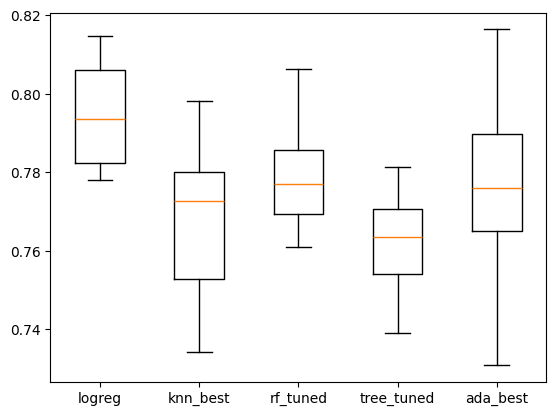

In [201]:
plt.boxplot(results, tick_labels = models.keys())
plt.show()

In [202]:
for name, model in models.items():
  model.fit(X_train_scaled, y_train)
  test_score = model.score(X_test_scaled, y_test)
  print("{} Test set Accuracy: {}".format(name, test_score))

logreg Test set Accuracy: 0.7984409799554566
knn_best Test set Accuracy: 0.7873051224944321
rf_tuned Test set Accuracy: 0.7906458797327395
tree_tuned Test set Accuracy: 0.7717149220489977
ada_best Test set Accuracy: 0.7861915367483296


In [204]:
for name, model in models.items():
  model.fit(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print("{} Test set Accuracy: {}".format(name, test_score))

logreg Test set Accuracy: 0.799554565701559
knn_best Test set Accuracy: 0.7917594654788419
rf_tuned Test set Accuracy: 0.7884187082405345
tree_tuned Test set Accuracy: 0.7750556792873051
ada_best Test set Accuracy: 0.7984409799554566


XGBoost

In [213]:
import xgboost as xgb
pipeline_xgb = Pipeline([("scaler", StandardScaler()),
 ("xgb", xgb.XGBClassifier())])


gbm_param_grid = {
    "xgb__learning_rate": np.arange(0.05, 1.05, 0.05),
    "xgb__subsample": np.arange(0.05, 1.05, 0.05),
    "xgb__max_depth": np.arange(3, 20, 1),
    "xgb__colsample_bytree": np.arange(0.05, 1.05, 0.05)
    }

cv_xgb = RandomizedSearchCV(estimator = pipeline_xgb,
                      param_distributions = gbm_param_grid,
                      n_iter = 25,
                      scoring = "accuracy",
                      cv = 6,
                      n_jobs = -1,
                      verbose = 1)

In [214]:
cv_xgb.fit(X_train, y_train)

Fitting 6 folds for each of 25 candidates, totalling 150 fits


RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_t...
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'xgb__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'xgb__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'xgb__subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='accuracy', verbose=1)

In [215]:
print(cv_xgb.best_params_)
print(cv_xgb.best_score_)

{'xgb__subsample': np.float64(1.0), 'xgb__max_depth': np.int64(16), 'xgb__learning_rate': np.float64(0.6500000000000001), 'xgb__colsample_bytree': np.float64(0.05)}
0.7844023763128068


In [242]:
models = { "logreg": pipeline_logreg,
          "knn_best": cv_knn.best_estimator_,
          "rf_tuned": cv_rf.best_estimator_,
          "tree_tuned": cv_dt.best_estimator_,
           "ada_best": adb_clf,
           "xgb_tuned": cv_xgb.best_estimator_}
results = []

In [243]:
for model in models.values():
  kf = KFold(n_splits = 8, random_state = 42, shuffle = True)
  cv_results = cross_val_score(model, X_train, y_train, cv = kf)
  results.append(cv_results)

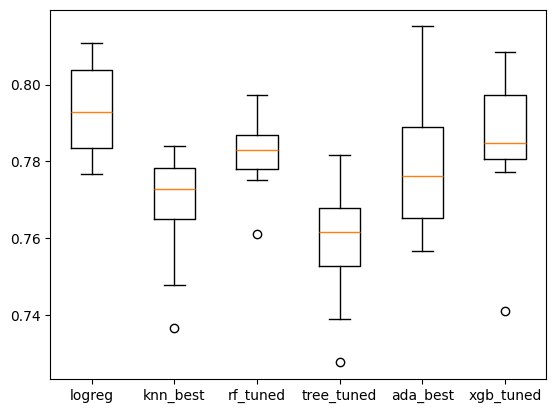

In [244]:
plt.boxplot(results, tick_labels = models.keys())
plt.show()

In [245]:
results = []
for model in models.values():
  kf = KFold(n_splits = 8, random_state = 42, shuffle = True)
  cv_results = cross_val_score(model, X_train, y_train, cv = kf, scoring = "f1")
  results.append(cv_results)

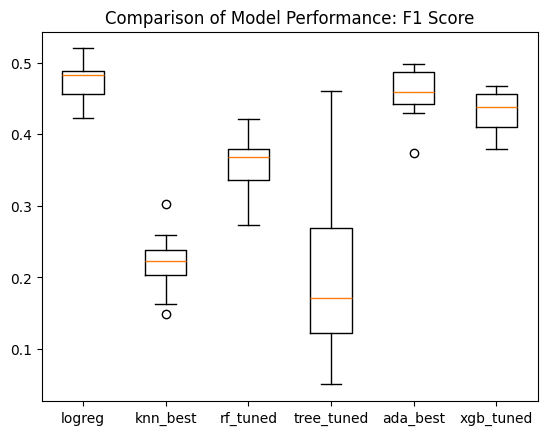

In [249]:
plt.boxplot(results, tick_labels = models.keys())
plt.title("Comparison of Model Performance: F1 Score")
plt.show()

In [240]:
for name, model in models.items():
  model.fit(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print("{} Test set Accuracy: {}".format(name, test_score))

logreg Test set Accuracy: 0.799554565701559
knn_best Test set Accuracy: 0.7917594654788419
rf_tuned Test set Accuracy: 0.7917594654788419
tree_tuned Test set Accuracy: 0.767260579064588
ada_best Test set Accuracy: 0.7884187082405345
xgb_tuned Test set Accuracy: 0.7873051224944321
